# Classification Project: Adult Census Income (UCI)

## 1. Problem Statement
We build a supervised **binary classification** model to predict whether an individual's annual income is **> $50K** (`income = 1`) or **<= $50K** (`income = 0`) using demographic and employment-related attributes.

## 2. UNSDG Alignment
This project aligns with **UN Sustainable Development Goal 8 (Decent Work and Economic Growth)** because it studies relationships between education, occupation, working hours, and income—key factors that inform policies for productive employment and improved living standards.

## 3. Dataset (required details)
**Dataset:** *Adult / Census Income* (UCI Machine Learning Repository)

- **Created / extracted:** Extracted from the **1994 U.S. Census database** by **Barry Becker**.
- **Donated / published on UCI:** **April 30, 1996**.
- **Access / source:** Downloaded as a CSV file from the UCI Machine Learning Repository.
- **Instances / features:** 48,842 rows and 14 input features (target not included in the 14).
- **Known issues:** Missing values exist for some categorical fields (often encoded as `?`).

**Primary reference:** UCI dataset page (Adult/Census Income).

## 4. Questions this dataset can answer (examples)
1. Which attributes (e.g., education level, occupation, working hours) are most associated with earning **> $50K**?
2. Are higher-income individuals older on average, or do they work more hours per week?
3. How does income vary by education and marital status?

---

> **Note:** The notebook uses a clean sklearn pipeline approach (imputation → encoding/scaling → model), so there is **no data leakage** between train and test.


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

FAST_MODE = True        # True = quicker experiments, False = full dataset run
SAMPLE_FRAC = 0.25

sns.set_theme(style="whitegrid")


## 3. Dataset (Adult / Census Income)

**Source:** UCI Machine Learning Repository (Adult / Census Income). The UCI page states the dataset was **donated on 30 April 1996**, and the extraction was done by **Barry Becker** from the **1994 US Census database**. (Commonly referenced contributors: Ron Kohavi and Barry Becker.)

**How the dataset was accessed in this notebook:** A local CSV file `adult.csv` (same schema as UCI Adult). If you do not have the file, download it from the UCI repository and rename to `adult.csv`.

### 3.1 Attributes (Features)
Each row represents one individual. The target label is `income`.

| Attribute | Type | Brief meaning |
|---|---:|---|
| age | numeric | Age in years |
| workclass | categorical | Employment type (e.g., Private, State-gov, Self-emp) |
| fnlwgt | numeric | Census sampling weight |
| education | categorical | Highest education level |
| education-num | numeric | Education level encoded as an integer |
| marital-status | categorical | Marital status |
| occupation | categorical | Occupation category |
| relationship | categorical | Relationship role in family |
| race | categorical | Race category |
| sex | categorical | Sex (Female/Male) |
| capital-gain | numeric | Capital gains |
| capital-loss | numeric | Capital losses |
| hours-per-week | numeric | Working hours per week |
| native-country | categorical | Country of origin |
| income (target) | categorical | `<=50K` or `>50K` |

### 3.2 Example questions the dataset can answer
1. Which attributes (education, occupation, hours/week, capital-gain, etc.) are most associated with earning **> $50K**?
2. How does **education level** affect the probability of earning **> $50K**?
3. Can we build a model that reliably predicts higher income while controlling for class imbalance?

### 3.3 Initial quality considerations
- The UCI Adult dataset includes **missing values** in some categorical columns (often encoded as `?`).
- The target is typically **imbalanced** (more `<=50K` than `>50K`), so we report **precision, recall, F1**, and also ROC-AUC / PR-AUC where useful.


**Interpretation **

This cell imports all libraries for data handling, visualization, machine learning, and evaluation. A fixed random seed is used so results are reproducible (same split and similar outcomes each run). FAST_MODE allows faster testing by sampling the dataset.

In [3]:
df = pd.read_csv("adult.csv", na_values=["?"])
print("Shape:", df.shape)
display(df.head())

df = df.copy()

# Clean whitespace for text columns
for c in df.select_dtypes(include="object").columns:
    df[c] = df[c].astype(str).str.strip()
    df.loc[df[c].str.lower() == "nan", c] = np.nan

# Ensure pandas NA becomes numpy nan (sklearn-friendly)
df = df.replace({pd.NA: np.nan})

TARGET = "income"
y_full = (df[TARGET] == ">50K").astype(int)
X_full = df.drop(columns=TARGET)


Shape: (48842, 15)


,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K


Interpretation:
Here we load the dataset and handle missing values (the dataset uses ? as missing). We also remove extra spaces from categorical values (like " Private"), which improves encoding quality. The target (income) is converted into binary classes: 1 for >50K and 0 for <=50K.

In [4]:
# Initial data quality check on raw (uncleaned) data
print("Missing values before cleaning:")
display(df.isna().sum()[df.isna().sum() > 0])

print("Duplicate rows before cleaning:", df.duplicated().sum())


Missing values before cleaning:


,0
workclass,2799
occupation,2809
native-country,857


Duplicate rows before cleaning: 52


In [5]:

# Data dictionary (feature descriptions)
data_dict = pd.DataFrame([
    ("age", "numeric (int)", "Age in years."),
    ("workclass", "categorical", "Employer type (e.g., Private, Self-emp, Government, etc.)."),
    ("fnlwgt", "numeric (int)", "Final sampling weight used by the Census Bureau (proxy for representation in population)."),
    ("education", "categorical", "Highest education level (string label)."),
    ("education-num", "numeric (int)", "Education level as an ordered numeric value."),
    ("marital-status", "categorical", "Marital status category."),
    ("occupation", "categorical", "Occupation category (e.g., Exec-managerial, Sales, etc.)."),
    ("relationship", "categorical", "Relationship / household role (e.g., Husband, Wife, Not-in-family)."),
    ("race", "categorical", "Race category."),
    ("sex", "binary categorical", "Sex (Female/Male)."),
    ("capital-gain", "numeric (int)", "Capital gains recorded for the year."),
    ("capital-loss", "numeric (int)", "Capital losses recorded for the year."),
    ("hours-per-week", "numeric (int)", "Hours worked per week."),
    ("native-country", "categorical", "Country of origin."),
    ("income (target)", "binary", "Target: >50K or <=50K annual income.")
], columns=["Attribute", "Type", "Description"])

display(data_dict)


,Attribute,Type,Description
0,age,numeric (int),Age in years.
1,workclass,categorical,"Employer type (e.g., Private, Self-emp, Govern..."
2,fnlwgt,numeric (int),Final sampling weight used by the Census Burea...
3,education,categorical,Highest education level (string label).
4,education-num,numeric (int),Education level as an ordered numeric value.
5,marital-status,categorical,Marital status category.
6,occupation,categorical,"Occupation category (e.g., Exec-managerial, Sa..."
7,relationship,categorical,"Relationship / household role (e.g., Husband, ..."
8,race,categorical,Race category.
9,sex,binary categorical,Sex (Female/Male).


In [6]:
# Stratified sampling and quick data quality checks

# Use a smaller, representative subset of data when FAST_MODE is enabled.
# This speeds up experimentation while keeping the class ratio similar.
if FAST_MODE:
    tmp = X_full.copy()

    # Add target temporarily so we can sample within each class
    tmp["_y"] = y_full

    # Sample within each class to preserve the original class distribution
    tmp = tmp.groupby("_y", observed=True).sample(
        frac=SAMPLE_FRAC,
        random_state=RANDOM_STATE
    )

    # Separate features and target again after sampling
    y = tmp["_y"]
    X = tmp.drop(columns="_y")

    print(f"FAST_MODE=True → using {len(X):,} rows")
else:
    # Full dataset for final training and reporting
    X, y = X_full, y_full
    print(f"FAST_MODE=False → using full dataset: {len(X):,} rows")

# Human-readable labels for the target classes
labels = {0: "<=50K", 1: ">50K"}

# Show class distribution (helps spot imbalance before modeling)
display(pd.DataFrame({
    "Class": [labels[i] for i in y.value_counts().sort_index().index],
    "Count": y.value_counts().sort_index().values,
    "Percent": (y.value_counts(normalize=True).sort_index() * 100).round(2).values
}))

# Check missing values in X (should be 0 if you already dropped missing rows)
missing_pct = (X.isna().mean() * 100).sort_values(ascending=False)
display(missing_pct[missing_pct > 0].round(2).to_frame("Missing %"))

# Check duplicates in the original dataframe (before/after cleaning depends on where df is defined)
print("Duplicate rows in raw df:", df.duplicated().sum())


FAST_MODE=True → using 12,211 rows


,Class,Count,Percent
0,<=50K,9289,76.07
1,>50K,2922,23.93


,Missing %
occupation,5.38
workclass,5.35
native-country,1.78


Duplicate rows in raw df: 52


Interpretation:
This cell checks dataset quality. The target distribution shows class imbalance (more <=50K than >50K), so F1-score and recall become important, not just accuracy. We also measure missing values and duplicates to understand cleaning needs.

Total missing values in X: 1527


,dtype,n_missing,missing_%,n_unique
occupation,object,657,5.38,14
workclass,object,653,5.35,8
native-country,object,217,1.78,40
education,object,0,0.00,16
fnlwgt,int64,0,0.00,10122
age,int64,0,0.00,71
marital-status,object,0,0.00,7
educational-num,int64,0,0.00,16
race,object,0,0.00,5
relationship,object,0,0.00,6


,count,mean,std,min,25%,50%,75%,max
age,12211.0,38.615019,13.732442,17.0,28.0,37.0,48.0,90.0
fnlwgt,12211.0,190447.901974,105206.654497,13769.0,118388.5,179010.0,238021.0,1366120.0
educational-num,12211.0,10.059864,2.569608,1.0,9.0,10.0,12.0,16.0
capital-gain,12211.0,954.274425,6749.141637,0.0,0.0,0.0,0.0,99999.0
capital-loss,12211.0,89.485710,409.065531,0.0,0.0,0.0,0.0,4356.0
hours-per-week,12211.0,40.620588,12.578172,1.0,40.0,40.0,45.0,99.0


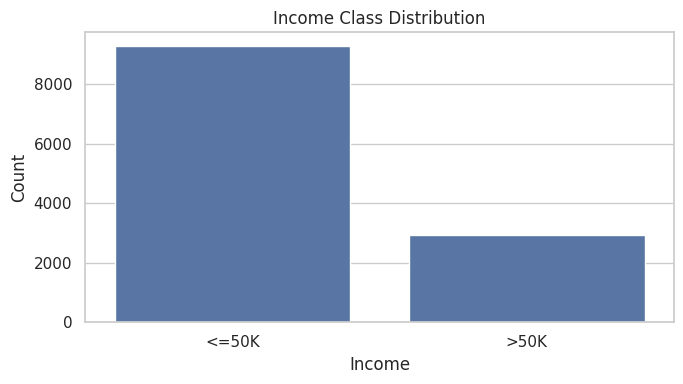

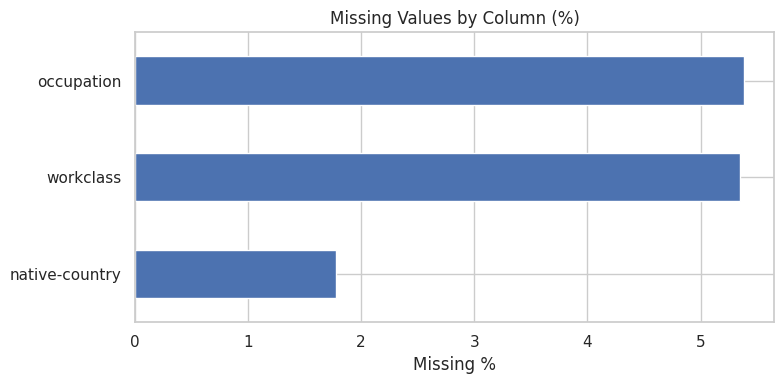

Numeric columns: ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
Categorical columns: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']


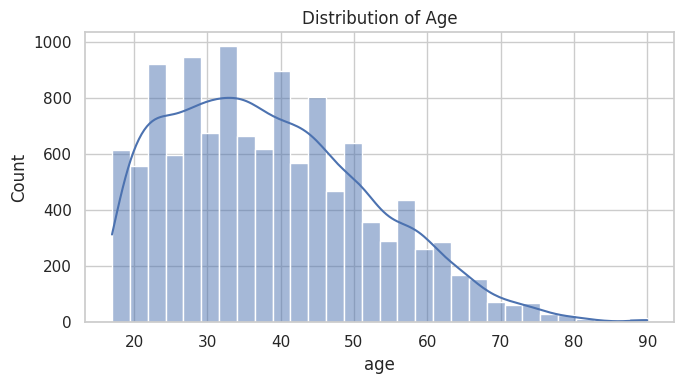

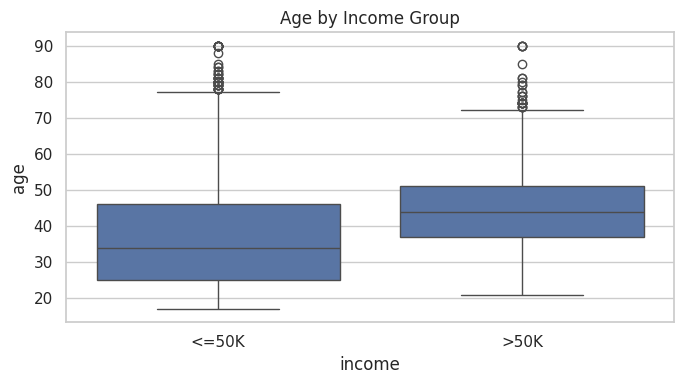

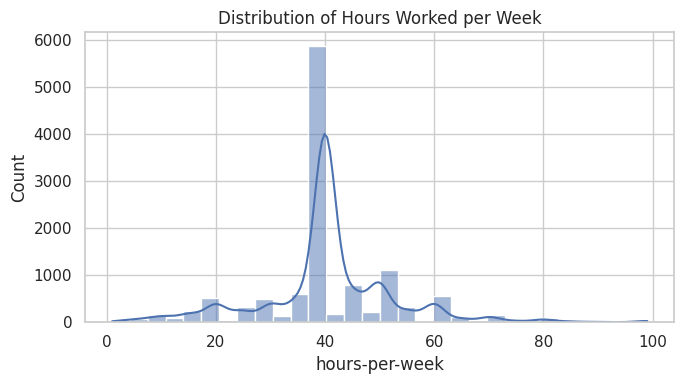

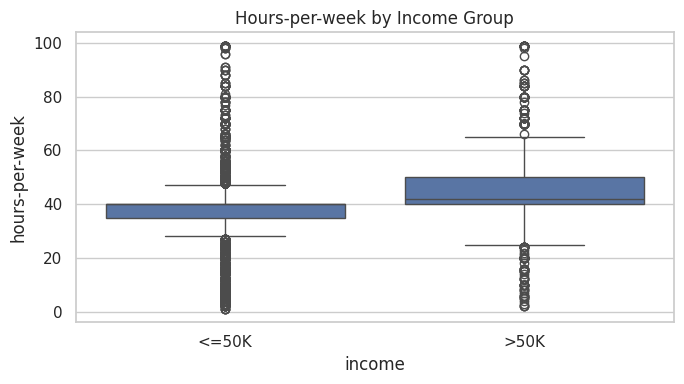

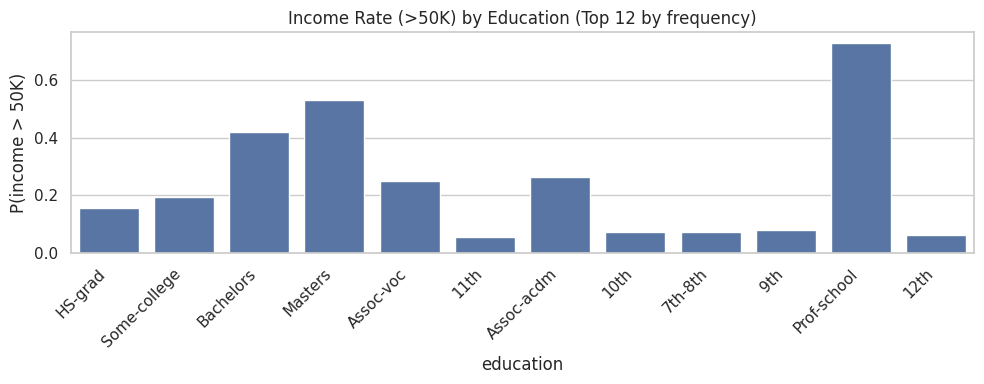

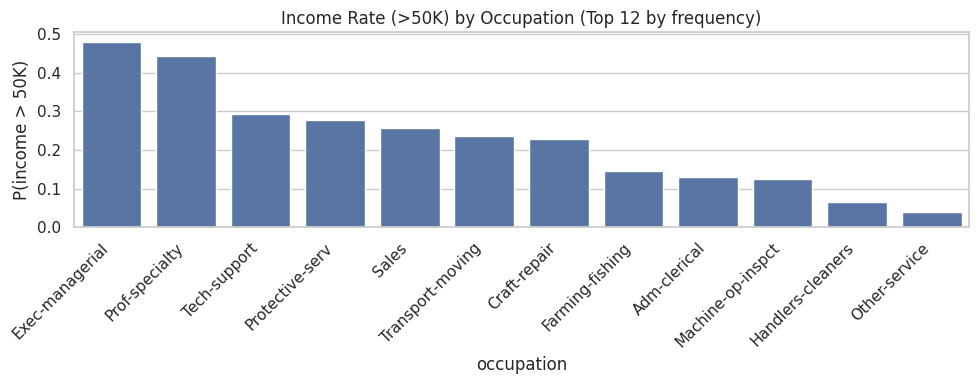

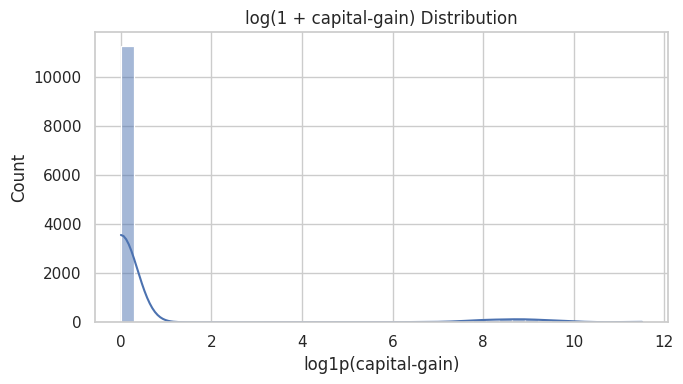

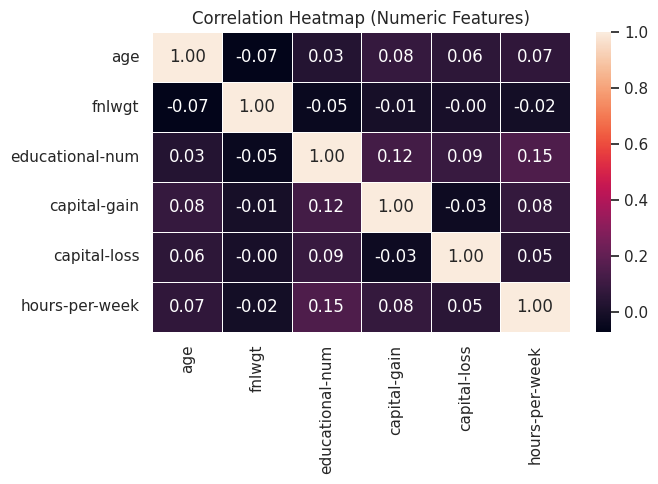

In [7]:

# 4. Exploratory Data Analysis (EDA)

# Sanity check after cleaning
print("Total missing values in X:", X.isna().sum().sum())

# Quick structural summary
display(pd.DataFrame({
    "dtype": X.dtypes,
    "n_missing": X.isna().sum(),
    "missing_%": (X.isna().mean()*100).round(2),
    "n_unique": X.nunique()
}).sort_values("missing_%", ascending=False))

# Summary statistics (numeric)
display(X.describe(include=[np.number]).T)

# 4.1 Target distribution (class imbalance check)
plt.figure(figsize=(7,4))
sns.countplot(x=y.map(labels))
plt.title("Income Class Distribution")
plt.xlabel("Income")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 4.2 Missingness overview
miss_nonzero = missing_pct[missing_pct > 0].sort_values()
if len(miss_nonzero) > 0:
    plt.figure(figsize=(8,4))
    miss_nonzero.plot(kind="barh")
    plt.title("Missing Values by Column (%)")
    plt.xlabel("Missing %")
    plt.tight_layout()
    plt.show()

# Identify numeric vs categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64", "float64"]).columns.tolist()
print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)

# 4.3 Age distribution + relationship with income
if "age" in X.columns:
    plt.figure(figsize=(7,4))
    sns.histplot(data=X, x="age", bins=30, kde=True)
    plt.title("Distribution of Age")
    plt.tight_layout()
    plt.show()

    tmp_plot = X[["age"]].copy()
    tmp_plot["income"] = y.map(labels)
    plt.figure(figsize=(7,4))
    sns.boxplot(data=tmp_plot, x="income", y="age")
    plt.title("Age by Income Group")
    plt.tight_layout()
    plt.show()

# 4.4 Hours-per-week and income
if "hours-per-week" in X.columns:
    plt.figure(figsize=(7,4))
    sns.histplot(data=X, x="hours-per-week", bins=30, kde=True)
    plt.title("Distribution of Hours Worked per Week")
    plt.tight_layout()
    plt.show()

    tmp_plot = X[["hours-per-week"]].copy()
    tmp_plot["income"] = y.map(labels)
    plt.figure(figsize=(7,4))
    sns.boxplot(data=tmp_plot, x="income", y="hours-per-week")
    plt.title("Hours-per-week by Income Group")
    plt.tight_layout()
    plt.show()

# 4.5 Education vs income (income rate)
if "education" in X.columns:
    edu_rate = pd.DataFrame({"education": X["education"], "y": y}).groupby("education")["y"].mean()
    edu_count = X["education"].value_counts()
    edu_plot = pd.DataFrame({"income_rate": edu_rate, "count": edu_count}).sort_values("count", ascending=False).head(12)
    plt.figure(figsize=(10,4))
    sns.barplot(x=edu_plot.index, y=edu_plot["income_rate"])
    plt.xticks(rotation=45, ha="right")
    plt.title("Income Rate (>50K) by Education (Top 12 by frequency)")
    plt.ylabel("P(income > 50K)")
    plt.tight_layout()
    plt.show()

# 4.6 Occupation vs income (top occupations)
if "occupation" in X.columns:
    occ_count = X["occupation"].value_counts().dropna()
    top_occ = occ_count.head(12).index
    occ_rate = pd.DataFrame({"occupation": X["occupation"], "y": y}).dropna().groupby("occupation")["y"].mean()
    occ_plot = occ_rate.loc[top_occ].sort_values(ascending=False)
    plt.figure(figsize=(10,4))
    sns.barplot(x=occ_plot.index, y=occ_plot.values)
    plt.xticks(rotation=45, ha="right")
    plt.title("Income Rate (>50K) by Occupation (Top 12 by frequency)")
    plt.ylabel("P(income > 50K)")
    plt.tight_layout()
    plt.show()

# 4.7 Capital gain is extremely right-skewed (many zeros). Use log1p for a clearer view.
if "capital-gain" in X.columns:
    cg = X["capital-gain"].fillna(0)
    plt.figure(figsize=(7,4))
    sns.histplot(np.log1p(cg), bins=40, kde=True)
    plt.title("log(1 + capital-gain) Distribution")
    plt.xlabel("log1p(capital-gain)")
    plt.tight_layout()
    plt.show()

# 4.8 Correlation heatmap (numeric features only)
if len(num_cols) >= 2:
    plt.figure(figsize=(7,5))
    sns.heatmap(X[num_cols].corr(numeric_only=True), annot=True, fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap (Numeric Features)")
    plt.tight_layout()
    plt.show()


### Key EDA Insights (what we learned)

- **Class imbalance:** The dataset contains more `<=50K` than `>50K`, so we prioritize **F1-score**, **recall**, and **ROC-AUC/PR-AUC** instead of only accuracy.
- **Missing values:** Missingness appears mainly in work-related categorical fields (e.g., *workclass*, *occupation*). We handle this with **imputation + one-hot encoding** in a preprocessing pipeline to avoid data leakage.
- **Age & hours worked:** Higher-income individuals generally show higher median *age* and higher *hours-per-week*.
- **Education & occupation:** Higher education levels and professional/managerial occupations have substantially higher `P(income > 50K)`.
- **Capital-gain:** Highly right-skewed (many zeros). The log1p view confirms a small group with very high gains.

These patterns justify (1) robust preprocessing, (2) models that can capture nonlinear interactions (e.g., Random Forest), and (3) evaluation beyond accuracy.


In [8]:
# Split the dataset into training and testing sets
# Stratification ensures both income classes are represented proportionally
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# Print shapes to verify the split
print("Train/Test:", X_train.shape, X_test.shape)

# Preprocessing for numerical features
# Median imputation is robust to outliers, followed by standard scaling
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Preprocessing for categorical features
# Missing values are filled with the most frequent category,
# then features are one-hot encoded
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Combine numerical and categorical preprocessing steps
# ColumnTransformer applies the correct pipeline to each feature type
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])


Train/Test: (9768, 14) (2443, 14)


Interpretation:
We split into train and test sets using stratification so the income class ratio stays similar in both splits. Then we build a preprocessing pipeline: numeric features are imputed with median and scaled, while categorical features are imputed with the most frequent value and one-hot encoded.

## 5.1 Neural Network Model (MLPClassifier)

We implement a **Multi-Layer Perceptron (MLP)** as the neural network classifier.

**Architecture (chosen for tabular data):**
- Input: preprocessed numeric + one-hot categorical features
- Hidden layers: **(64, 32)** neurons
- Activation: **ReLU** (non-linear, works well for deep networks)
- Output layer: **sigmoid**-like probability via sklearn's internal logistic output for binary classification

**Training setup:**
- Loss: **log-loss (cross-entropy)** (default for classification in `MLPClassifier`)
- Optimizer: **Adam** (default, good general-purpose adaptive optimizer)
- Regularization: L2 controlled by `alpha`
- Early stopping: enabled to reduce overfitting

We evaluate using metrics suitable for imbalanced classes: **F1**, **recall**, and (when available) **ROC-AUC/PR-AUC**.



Logistic Regression (Baseline)
              precision    recall  f1-score   support

       <=50K       0.87      0.93      0.90      1858
        >50K       0.73      0.55      0.63       585

    accuracy                           0.84      2443
   macro avg       0.80      0.74      0.76      2443
weighted avg       0.83      0.84      0.83      2443



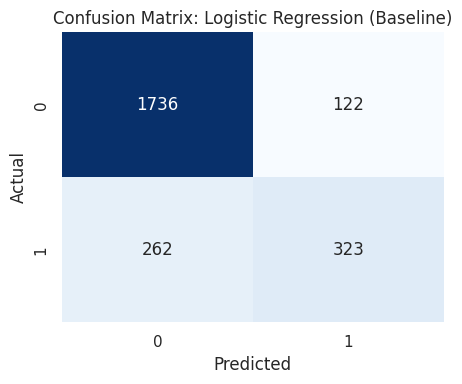


Random Forest (Baseline)
              precision    recall  f1-score   support

       <=50K       0.88      0.93      0.90      1858
        >50K       0.73      0.60      0.66       585

    accuracy                           0.85      2443
   macro avg       0.81      0.76      0.78      2443
weighted avg       0.84      0.85      0.85      2443



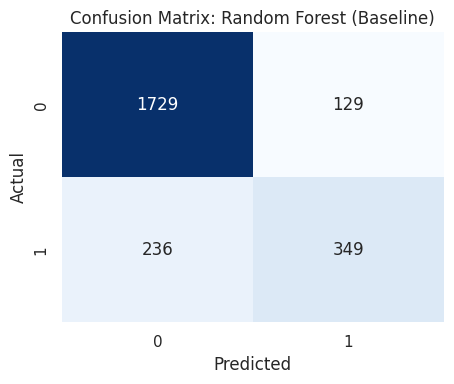


Neural Network MLP (Baseline)
              precision    recall  f1-score   support

       <=50K       0.89      0.93      0.91      1858
        >50K       0.73      0.63      0.68       585

    accuracy                           0.86      2443
   macro avg       0.81      0.78      0.79      2443
weighted avg       0.85      0.86      0.85      2443



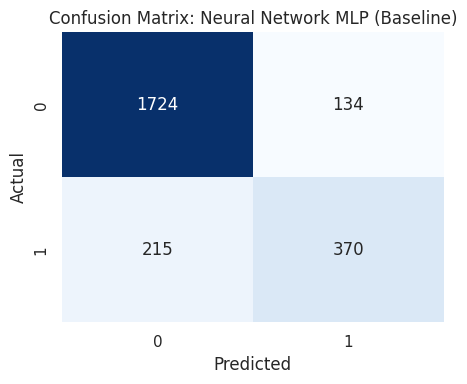

,Model,Accuracy,Precision,Recall,F1,ROC-AUC,PR-AUC
2,Neural Network MLP (Baseline),0.8571,0.7341,0.6325,0.6795,0.9084,0.7747
1,Random Forest (Baseline),0.8506,0.7301,0.5966,0.6566,0.9025,0.7659
0,Logistic Regression (Baseline),0.8428,0.7258,0.5521,0.6272,0.8984,0.7521


In [9]:
# Baseline Models (2 Classical + 1 Neural Network) and Evaluation

# Extra metrics and curve utilities (useful when classes are not perfectly balanced)
from sklearn.metrics import roc_auc_score, average_precision_score, RocCurveDisplay, PrecisionRecallDisplay

def evaluate(model, name, show_curves=False):
    """Train the model and evaluate on the test set using multiple classification metrics."""

    # Fit the model on training data
    model.fit(X_train, y_train)

    # Predict class labels on the test set
    pred = model.predict(X_test)

    # Try to get predicted probabilities for ROC-AUC and PR-AUC
    # Not all models support predict_proba, so we check safely
    proba = None
    if hasattr(model, "predict_proba"):
        try:
            proba = model.predict_proba(X_test)[:, 1]   # probability of the positive class (>50K)
        except Exception:
            proba = None

    # Print a detailed classification report (precision/recall/F1 per class)
    print(f"\n{name}")
    print(classification_report(y_test, pred, target_names=["<=50K", ">50K"], zero_division=0))

    # Confusion matrix helps explain model errors clearly in viva
    cm = confusion_matrix(y_test, pred)
    plt.figure(figsize=(4.7, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Store core metrics for later comparison across models
    metrics = {
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "F1": f1_score(y_test, pred, zero_division=0),
    }

    # ROC-AUC and PR-AUC require probabilities, so compute only if available
    # PR-AUC is especially informative when the positive class is smaller
    if proba is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_test, proba)
        metrics["PR-AUC"] = average_precision_score(y_test, proba)

        # Optional: show ROC and Precision–Recall curves if requested
        if show_curves:
            RocCurveDisplay.from_predictions(y_test, proba)
            plt.title(f"ROC Curve: {name}")
            plt.tight_layout()
            plt.show()

            PrecisionRecallDisplay.from_predictions(y_test, proba)
            plt.title(f"Precision–Recall Curve: {name}")
            plt.tight_layout()
            plt.show()

    return metrics

# Logistic Regression baseline
# Good interpretable linear baseline; saga solver works well with larger feature spaces (after one-hot encoding)
logreg = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(max_iter=3000, solver="saga", n_jobs=-1, random_state=RANDOM_STATE))
])

# Random Forest baseline
# Strong non-linear model that can capture feature interactions without heavy assumptions
rf = Pipeline([
    ("prep", preprocess),
    ("clf", RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=RANDOM_STATE))
])

# Neural network baseline (MLP)
# Early stopping helps avoid overfitting by stopping training when validation performance stops improving
mlp = Pipeline([
    ("prep", preprocess),
    ("clf", MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        early_stopping=True,
        alpha=1e-4,                # small L2 regularization to reduce overfitting
        learning_rate_init=1e-3,
        max_iter=60 if FAST_MODE else 150,   # fewer iterations in FAST_MODE to save time
        random_state=RANDOM_STATE
    ))
])

# Run evaluation for each baseline model and collect results in a list
baseline = []
baseline.append(evaluate(logreg, "Logistic Regression (Baseline)"))
baseline.append(evaluate(rf, "Random Forest (Baseline)"))
baseline.append(evaluate(mlp, "Neural Network MLP (Baseline)"))

# Convert results into a DataFrame for easy comparison
# Sorting by F1 is useful when class imbalance is present
baseline_df = pd.DataFrame(baseline).sort_values("F1", ascending=False)
display(baseline_df.round(4))


Best LR params: {'clf__C': 0.1, 'clf__class_weight': 'balanced', 'clf__penalty': 'l2', 'clf__solver': 'saga'}
Best LR CV F1: 0.6695
Best RF params: {'clf__class_weight': None, 'clf__max_depth': 20, 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
Best RF CV F1: 0.6551

Logistic Regression (Tuned)
              precision    recall  f1-score   support

       <=50K       0.94      0.79      0.86      1858
        >50K       0.56      0.83      0.67       585

    accuracy                           0.80      2443
   macro avg       0.75      0.81      0.76      2443
weighted avg       0.85      0.80      0.81      2443



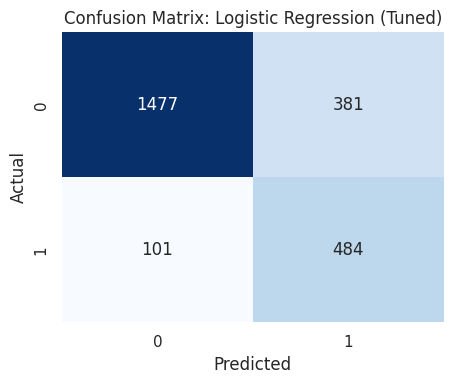

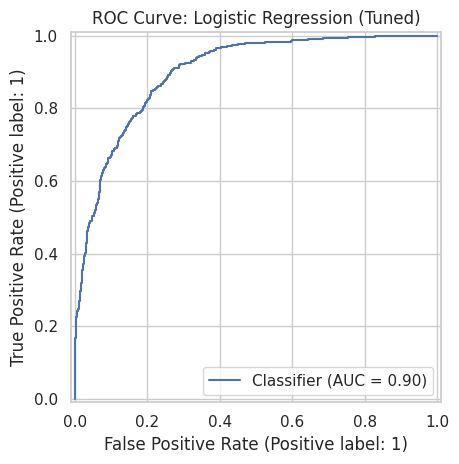

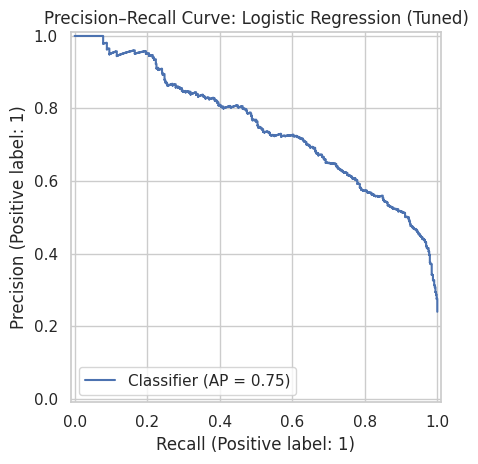


Random Forest (Tuned)
              precision    recall  f1-score   support

       <=50K       0.88      0.95      0.91      1858
        >50K       0.77      0.59      0.67       585

    accuracy                           0.86      2443
   macro avg       0.83      0.77      0.79      2443
weighted avg       0.85      0.86      0.85      2443



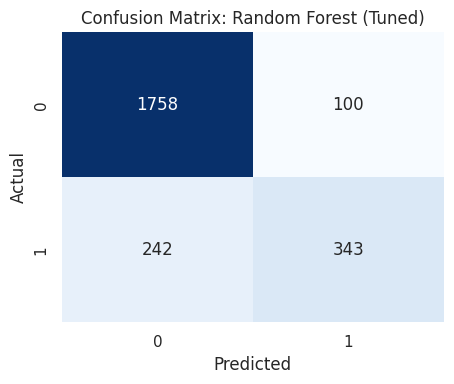

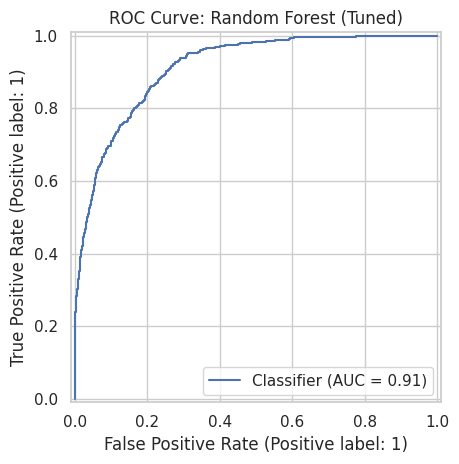

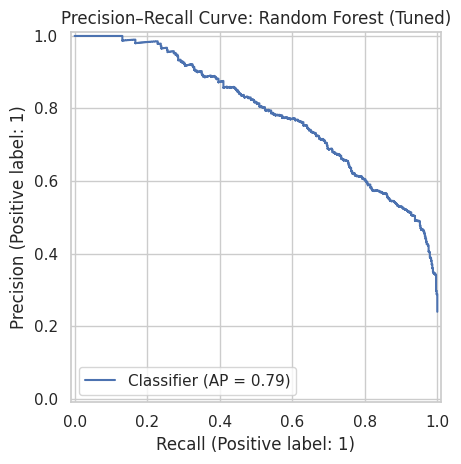

                         Model  Accuracy  Precision  Recall      F1  ROC-AUC  \
0  Logistic Regression (Tuned)    0.8027     0.5595  0.8274  0.6676   0.8999   
1        Random Forest (Tuned)    0.8600     0.7743  0.5863  0.6673   0.9129   

   PR-AUC  
0  0.7503  
1  0.7900  


In [10]:
# Stratified CV (reduced folds to cut runtime)
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

# ---------- Logistic Regression (light grid, fast) ----------
gs_lr = GridSearchCV(
    logreg,
    {
        "clf__penalty": ["l2"],              # l2 only (fast, stable)
        "clf__C": [0.1, 1],                  # sufficient range
        "clf__class_weight": [None, "balanced"],
        "clf__solver": ["saga"],
    },
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

gs_lr.fit(X_train, y_train)

# ---------- Random Forest (light grid, fast) ----------
gs_rf = GridSearchCV(
    rf,
    {
        "clf__n_estimators": [200],          # single strong value
        "clf__max_depth": [None, 20],
        "clf__min_samples_split": [2, 10],
        "clf__min_samples_leaf": [1, 2],
        "clf__class_weight": [None],
    },
    scoring="f1",
    cv=cv,
    n_jobs=-1
)

gs_rf.fit(X_train, y_train)

# Results
print("Best LR params:", gs_lr.best_params_)
print("Best LR CV F1:", round(gs_lr.best_score_, 4))
print("Best RF params:", gs_rf.best_params_)
print("Best RF CV F1:", round(gs_rf.best_score_, 4))

best_lr = gs_lr.best_estimator_
best_rf = gs_rf.best_estimator_

tuned = []
tuned.append(evaluate(best_lr, "Logistic Regression (Tuned)", show_curves=True))
tuned.append(evaluate(best_rf, "Random Forest (Tuned)", show_curves=True))

print(pd.DataFrame(tuned).round(4).sort_values("F1", ascending=False))


Interpretation:
Hyperparameter tuning tries multiple settings using cross-validation and selects the best based on F1-score. This improves reliability because results are averaged across multiple folds rather than depending on a single train/test split.


Final Logistic Regression
              precision    recall  f1-score   support

       <=50K       0.94      0.79      0.86      1858
        >50K       0.56      0.83      0.67       585

    accuracy                           0.80      2443
   macro avg       0.75      0.81      0.76      2443
weighted avg       0.85      0.80      0.81      2443



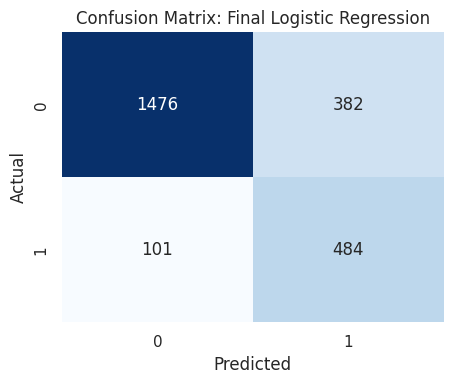

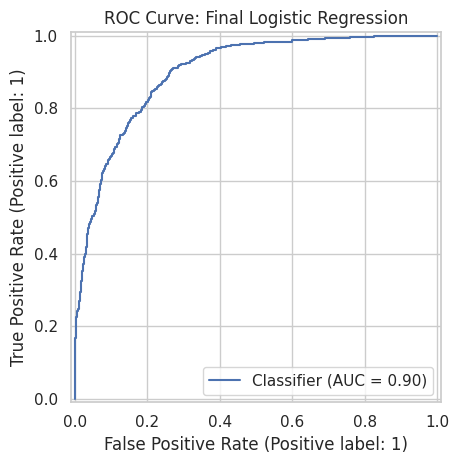

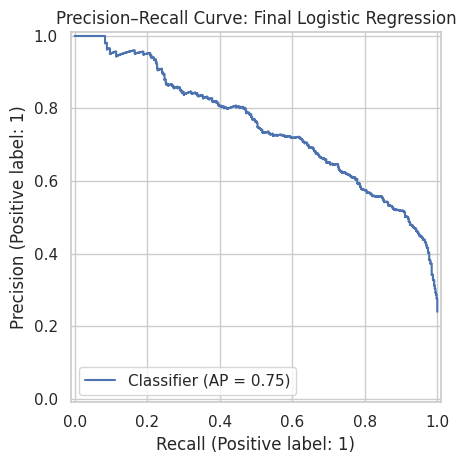


Final Random Forest
              precision    recall  f1-score   support

       <=50K       0.88      0.94      0.91      1858
        >50K       0.77      0.59      0.67       585

    accuracy                           0.86      2443
   macro avg       0.83      0.77      0.79      2443
weighted avg       0.85      0.86      0.85      2443



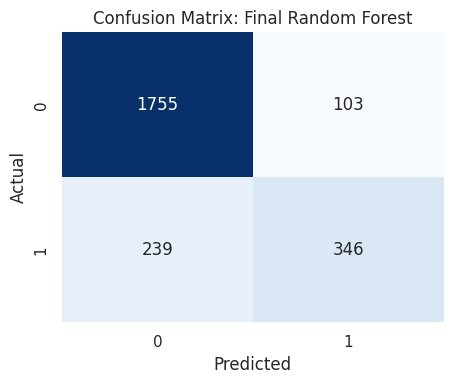

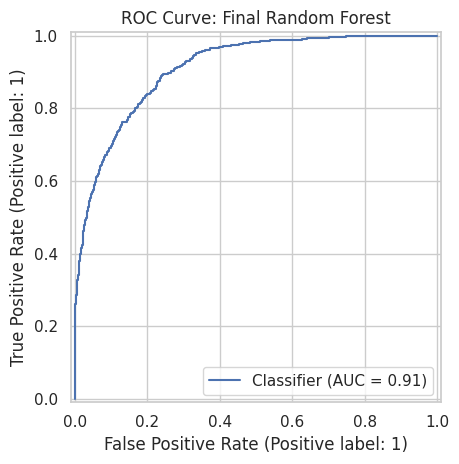

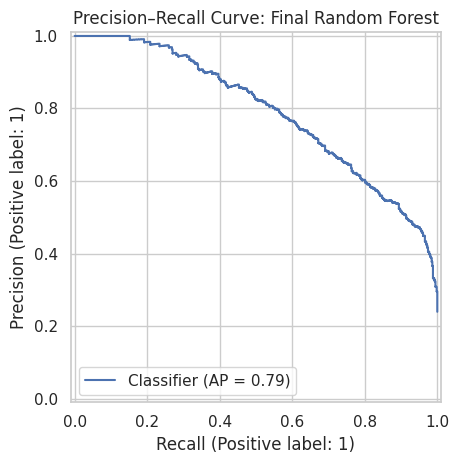

                       Model  Selected Features   CV F1  Accuracy  Precision  \
1        Final Random Forest                 20  0.6451    0.8600     0.7706   
0  Final Logistic Regression                 62  0.6708    0.8023     0.5589   

   Recall      F1  ROC-AUC  PR-AUC  
1  0.5915  0.6692   0.9108  0.7911  
0  0.8274  0.6671   0.8996  0.7497  


In [11]:
# ---------- Fast feature counter (NO refit) ----------
def count_selected_features_fitted(pipeline):
    selector = pipeline.named_steps.get("select", None)
    if selector is None:
        return None
    if hasattr(selector, "get_support"):
        return int(selector.get_support().sum())
    return None


# ---------- Final Logistic Regression (light) ----------
lr_fs = Pipeline([
    ("prep", preprocess),
    ("select", SelectFromModel(
        LogisticRegression(
            penalty="l1",
            solver="saga",
            C=1.0,
            max_iter=2000,
            random_state=RANDOM_STATE
        )
    )),
    ("clf", best_lr.named_steps["clf"])
])


# ---------- Final Random Forest (light) ----------
rf_fs = Pipeline([
    ("prep", preprocess),
    ("select", SelectFromModel(
        RandomForestClassifier(
            n_estimators=200,     # reduced
            max_depth=20,
            random_state=RANDOM_STATE,
            n_jobs=-1
        )
    )),
    ("clf", best_rf.named_steps["clf"])
])


final_results = []

for model, name in [
    (lr_fs, "Final Logistic Regression"),
    (rf_fs, "Final Random Forest")
]:
    # single CV pass (cheap)
    cv_f1 = cross_val_score(
        model,
        X_train,
        y_train,
        cv=3,                  # reduced folds
        scoring="f1",
        n_jobs=-1
    ).mean()

    # fit ONCE
    model.fit(X_train, y_train)

    n_feat = count_selected_features_fitted(model)

    metrics = evaluate(model, name, show_curves=True)
    metrics["Selected Features"] = n_feat
    metrics["CV F1"] = cv_f1

    final_results.append(metrics)


final_table = pd.DataFrame(final_results)

cols = [
    "Model", "Selected Features", "CV F1",
    "Accuracy", "Precision", "Recall",
    "F1", "ROC-AUC", "PR-AUC"
]

final_table = final_table[[c for c in cols if c in final_table.columns]].round(4)

print(final_table.sort_values("F1", ascending=False))


## 7. Feature Selection (embedded methods)

We apply **embedded feature selection** because it selects features *during model training* and naturally matches our models:

1. **Logistic Regression (L1 penalty)**: L1 regularization drives unimportant coefficients to **exactly zero**, so we can keep only the non-zero (important) encoded features.
2. **Random Forest feature importance**: Tree-based models compute impurity-based importances; `SelectFromModel` retains the most informative features based on importance thresholding.

Why this is suitable here:
- The dataset contains many categorical variables; one-hot encoding creates **many sparse features**. Feature selection reduces dimensionality, can improve generalization, and makes the model easier to explain.

---
